In [1]:
import pymongo
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns
import os
import pandas as pd
import scipy.optimize as opt
import statsmodels.formula.api as sm

sns.set_style('white')

%matplotlib inline

dump_dir = ''
client = pymongo.MongoClient('localhost', 27017)
db = client.gamesdb

In [2]:
# styling for figures
sns.set_style('white')
sns.set_context('paper')
sns.set_palette(sns.dark_palette('grey'))

matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.default'] = 'rm'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.major.size'] = 4
matplotlib.rcParams['ytick.major.size'] = 4


greens = sns.cubehelix_palette(n_colors=28, start=2.0, rot=.2, gamma=1, hue=.8, light=.8, dark=.15)

bayes_ci = .95
bmvs = lambda x: sts.bayes_mvs(x, alpha=bayes_ci)

%matplotlib inline

## AI

In [2]:
C = db.turing
cursor = C.find({'task':'AI'})

output_cols = ['user_name', 'opponent', 'color', 'bp', 'wp', 'response', 'rt', 'ts', 'status']

AI = pd.DataFrame(list(cursor))

In [3]:
print(AI.user_name.unique())
AI.tail()

[u'RR' u'SR' u'JC' u'MJ' u'OM' u'CR' u'AV' u'BB' u'FD' u'adfjk' u'bas'
 u'AF' u'SD' u'ARS' u'DT' u'AJ' u'TCK' u'GK' u'TW' u'weiji' u'DX' u'CW'
 u'AP']


,_id,bp,color,gi,initials,mt,mxy,opponent,response,rt,status,task,ts,user_name,wp
11533,582e1fbd9100de2d841b29d3,000000100000100000000000000000010000,1,25,1479414487358,"1479417787774,1479417789098,1479417789168,1479...","816,524;816,525;816,526;816,527;816,528;816,52...",2,29,3565,playing,AI,1479417794784,AP,000000000000010000000100000001000000
11534,582e1fc39100de2d841b29d4,000001100000100000000000000000010000,1,25,1479414487358,"1479417794794,1479417796502,1479417796512,1479...","721,589;720,589;719,589;718,589;718,588;717,58...",2,22,1979,playing,AI,1479417800401,AP,000000000000010000000110000001000000
11535,582e1fc99100de2d841b29d5,000001100000100000001000000000010000,1,25,1479414487358,"1479417800401,1479417800684,1479417800704,1479...","935,475;934,475;933,475;932,475;932,476;931,47...",2,4,1844,playing,AI,1479417806328,AP,000010000000010000000110000001000000
11536,582e1fcf9100de2d841b29d6,000001100000100000001000010000010000,1,25,1479414487358,"1479417806328,1479417806392,1479417806520,1479...","934,225;935,225;935,226;935,227;935,228;934,23...",2,24,4824,playing,AI,1479417812367,AP,000010000000010000000110100001000000
11537,582e1fd29100de2d841b29d7,000001100010100000001000010000010000,1,25,1479414487358,"1479417812367,1479417812871,1479417812881,1479...","1216,517;1215,517;1214,517;1213,517;1212,517;1...",2,23,883,win,AI,1479417814975,AP,000010000000010000000111100001000000


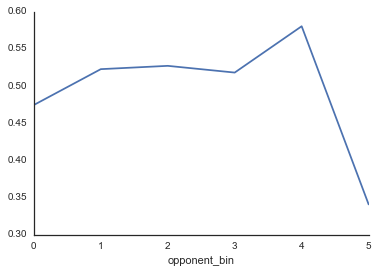

In [6]:
AI_out = AI.loc[AI.status != 'ready', output_cols]
AI_out['new_game'] = AI.bp.map(lambda x: int(np.array(list(x)).astype(int).sum()==1))
AI_out['last_move'] = AI_out['new_game'].shift(-1)
AI_out['status_code'] = AI_out.status.map(lambda x: 1 if x=='win' else 0)
AI_out['opponent'] = AI_out['opponent'].astype(int)
AI_out['opponent_bin'] = AI_out['opponent'] // 5
winfrac = AI_out.loc[AI_out.last_move==1, :].pivot_table(
    index='opponent_bin', values='status_code', aggfunc=np.mean
).sort_index()

winfrac.plot()
sns.despine()

# Turing

In [3]:
cursor = db.test_collection.find()
turing = pd.DataFrame(list(cursor))
turing = turing.loc[:, ['user_name', 'clip_id', 'choice', 'feedback', 'timestamp']]
print(turing.user_name.unique())
turing.head()

[u'bas' u'kjg' u'asdf' u'adsf' u'chg' u'sdv' u'dbgz' u'c' u'dfb' u'adf'
 u'ad' u'lkuhqljkh' u'kjh' u'vu' u'SR' u'bvf' u'RR' u'JC' u'tes' u'MJ'
 u'test' u'OM' u'gianni' u'BB' u'AV' u'FD' u'dsfv' u'yunqi' u'adfjk'
 u'badsafgdsdg' u'don' u'Weiji' u'adfads' u'admin' u'AF' u'SD' u'ARS' u'DT'
 u'AJ' u'TK' u'GK' u'TW' u'DX' u'AP' u'CW']


,user_name,clip_id,choice,feedback,timestamp
0,bas,93,20,NaN,1475621646464
1,bas,37,74,NaN,1475621663519
2,bas,1,74,NaN,1475621691617
3,bas,47,42,NaN,1475621713681
4,bas,51,36,NaN,1475621742946


In [4]:
names = ['AF','SD','ARS','DT','AJ','TK','GK','TW','DX','AP','CW']
g = turing.loc[turing.user_name.isin(names), :]
g['correct'] = g['feedback'].map(lambda x: x=='true').astype(int)
g['discard'] = g['feedback'].map(lambda x: x!='true' and x!='false').astype(int)
g = g.loc[g.discard == 0]
g.tail()
#g.to_csv(dump_dir + 'turing.csv')

C:\Users\yunqi\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\yunqi\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,user_name,clip_id,choice,feedback,timestamp,correct,discard
4059,CW,70,75,true,1479509100510,1,0
4060,CW,138,76,false,1479509117557,0,0
4061,CW,75,75,false,1479509126942,0,0
4062,CW,23,78,true,1479509153621,1,0
4063,CW,31,84,false,1479509162638,0,0


In [5]:
print sts.bayes_mvs(g.correct, alpha=.95) #.loc[g.user_name=='BB', :]
print sts.bayes_mvs(g.loc[g.user_name==names[4], 'correct'].values.astype(int))

(Mean(statistic=0.56212121212121213, minmax=(0.54026839473661203, 0.58397402950581223)), Variance(statistic=0.24614095500459132, minmax=(0.23080840552012996, 0.26147350448905265)), Std_dev(statistic=0.49612594671574206, minmax=(0.48067367135506012, 0.51157822207642401)))
(Mean(statistic=0.62222222222222223, minmax=(0.56230589040742651, 0.68213855403701795)), Variance(statistic=0.23904582548650349, minmax=(0.20032059345496875, 0.28386108143694899)), Std_dev(statistic=0.48823305014087265, minmax=(0.44757188635454875, 0.53278614981711836)))


In [6]:
g_length = pd.read_csv(dump_dir+'turing.csv')
g2 = g_length.groupby([g_length.user_name,g_length.length]).mean().reset_index()
g2.head()

,user_name,length,Unnamed: 0,clip_id,choice,feedback,timestamp,correct,discard,confidence,mean_confi,delta_confi
0,AF,1,2158.125000,86.125000,58.000000,0.250000,1.480000e+12,0.250000,0.0,11.250000,10.388889,0.861111
1,AF,2,2164.363636,67.818182,48.909091,0.545455,1.480000e+12,0.545455,0.0,9.636364,10.388889,-0.752525
2,AF,3,2170.000000,83.272727,49.454545,0.545455,1.480000e+12,0.545455,0.0,10.727273,10.388889,0.338384
3,AF,4,2189.000000,125.666667,49.000000,0.666667,1.480000e+12,0.666667,0.0,10.777778,10.388889,0.388889
4,AF,5,2176.071429,93.071429,41.928571,0.714286,1.480000e+12,0.714286,0.0,11.357143,10.388889,0.968254


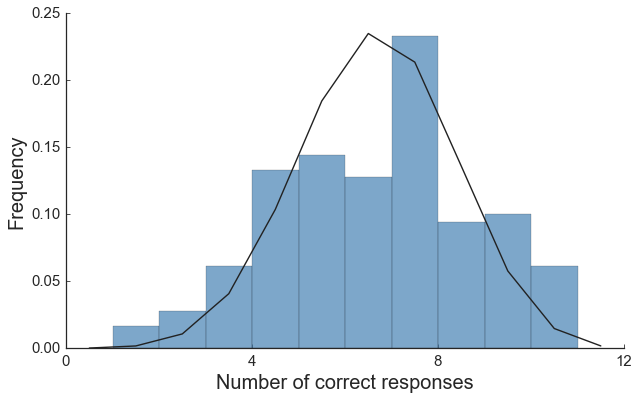

In [56]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

g_id = g_length.groupby([g_length.clip_id]).sum().reset_index()

# binomial
x = np.arange(0,12,1)
y =  sts.binom.pmf(x,11,0.56)
plt.plot(x+0.5,y)

# histogram of percentage correct
plt.hist(g_id.correct, bins=np.arange(0, 12, 1), alpha=.7, normed=True, color='steelblue')

plt.setp(
    axes, 
    ylabel='Frequency', xlabel='Number of correct responses'
)

plt.xticks([0,4,8,12])

sns.despine()

<function seaborn.utils.despine>

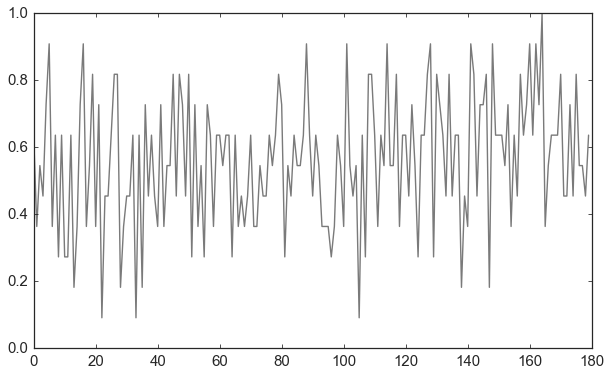

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))
plt.plot(g_id.clip_id, g_id.correct,alpha=0.6)

axes.set_xlim([0,180])
sns.despine

In [8]:
g_ave = g_length.groupby('user_name').mean().reset_index()
g_ave

,user_name,Unnamed: 0,clip_id,choice,feedback,timestamp,correct,discard,length,confidence,mean_confi,delta_confi
0,AF,2173.5,89.5,50.833333,0.511111,1.480000e+12,0.511111,0.0,9.588889,10.388889,10.388889,-1.111111e-07
1,AJ,2893.5,89.5,42.344444,0.622222,1.480000e+12,0.622222,0.0,9.588889,33.566667,33.566667,-3.333333e-07
2,AP,3793.5,89.5,51.394444,0.594444,1.480000e+12,0.594444,0.0,9.588889,20.905556,20.905556,-4.444444e-07
3,ARS,2533.5,89.5,51.166667,0.577778,1.480000e+12,0.577778,0.0,9.588889,39.555556,39.555556,-4.444444e-07
4,CW,3973.5,89.5,54.977778,0.594444,1.480000e+12,0.594444,0.0,9.588889,28.600000,28.600000,-3.454027e-16
5,DT,2713.5,89.5,43.950000,0.600000,1.480000e+12,0.600000,0.0,9.588889,17.550000,17.550000,-2.210577e-15
6,DX,3613.5,89.5,45.877778,0.627778,1.480000e+12,0.627778,0.0,9.588889,31.266667,31.266667,-3.333333e-07
7,GK,3253.5,89.5,52.150000,0.466667,1.480000e+12,0.466667,0.0,9.588889,13.572222,13.572222,2.222222e-07
8,SD,2353.5,89.5,53.494444,0.527778,1.480000e+12,0.527778,0.0,9.588889,27.338889,27.338889,-1.111111e-07
9,TK,3073.5,89.5,51.944444,0.566667,1.480000e+12,0.566667,0.0,9.588889,16.255556,16.255556,-4.444444e-07


In [58]:
length = g2.length.unique()
length

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 23, 24, 25, 27, 28, 34, 35], dtype=int64)

In [10]:
g2.loc[g2.user_name==names[0], 'choice'].values.astype(int).size

28

LinregressResult(slope=0.15025760201716884, intercept=-1.3673533000131912, rvalue=0.47184053001791115, pvalue=0.011246938956792057, stderr=0.055063961271347953)


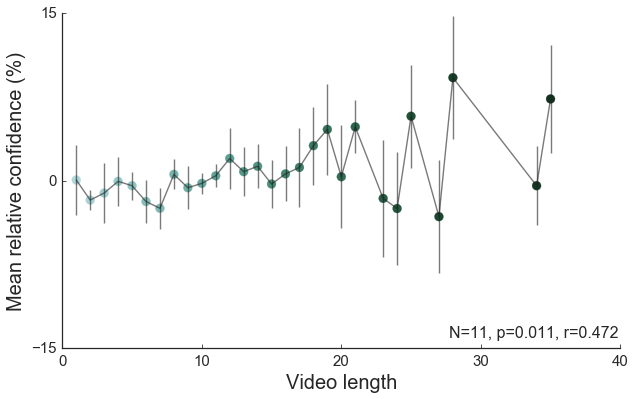

In [55]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

#x = g2.loc[g2.user_name==names[8], 'length'].values.astype(int)
#y = g2.loc[g2.user_name==names[8], 'delta_confi'].values.astype(int)
#x = g2.length.values.astype(int)
#y = g2.delta_confi.values.astype(int)
#print(sts.linregress(x, y))
#plt.plot(x, y, alpha=0.4,linewidth=0.4)
#plt.scatter(x,y,s=30)

g2_len = dict()
for i in range(0,28,1):
    g2_len[i] = g2.loc[g2.length==length[i]]

y = [np.mean(g2_len[i]['delta_confi']) for i in range(0,28,1)]
yerr = [1.96*np.std(g2_len[i]['delta_confi'])/np.sqrt(11) for i in range(0,28,1)]
axes.errorbar(length, y, yerr,alpha=0.6)

g2_ave = g2.groupby('length').mean().reset_index()
print(sts.linregress(g2_ave.length, g2_ave.delta_confi))

#plt.plot(g2_ave.length, g2_ave.delta_confi)
plt.scatter(g2_ave.length, g2_ave.delta_confi,s=80,color=greens)

plt.setp(
    axes, 
    ylabel='Mean relative confidence (%)', xlabel='Video length'
)

axes.set_xlim([0,40])
axes.set_ylim([-15,15])
plt.xticks([0,10,20,30,40])
#plt.yticks([-10,0,10,20])
plt.yticks([-15,0,15])

#text = 'N=30, p<-0.001, r=0.222'
text = 'N=11, p=0.011, r=0.472'
plt.figtext(0.78,0.16,text, fontsize=16, ha='center', va='center', transform=axes.transAxes)

sns.despine()

LinregressResult(slope=0.40957391932322296, intercept=-3.6031451268220072, rvalue=0.58633247252195309, pvalue=0.0010417974133184753, stderr=0.11097483177704788)


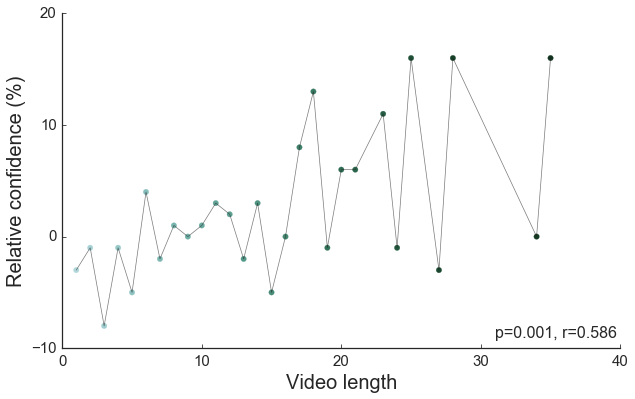

In [185]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

x = g2.loc[g2.user_name==names[8], 'length'].values.astype(int)
y = g2.loc[g2.user_name==names[8], 'delta_confi'].values.astype(int)
print(sts.linregress(x, y))
plt.plot(x, y, alpha=0.6,linewidth=0.7)
plt.scatter(x,y,s=30,color=greens)

plt.setp(
    axes, 
    ylabel='Relative confidence (%)', xlabel='Video length'
)

axes.set_xlim([0,40])
axes.set_ylim([-10,20])
plt.xticks([0,10,20,30,40])
plt.yticks([-10,0,10,20])

text = 'p=0.001, r=0.586'
plt.figtext(0.81,0.16,text, fontsize=16, ha='center', va='center', transform=axes.transAxes)

sns.despine()

In [192]:
g3 = g2.groupby('length').mean().reset_index()
g2_len[1]

,user_name,length,Unnamed: 0,clip_id,choice,feedback,timestamp,correct,discard,confidence,mean_confi,delta_confi
1,AF,2,2164.363636,67.818182,48.909091,0.545455,1.480000e+12,0.545455,0.0,9.636364,10.388889,-0.752525
29,AJ,2,2898.363636,67.818182,18.909091,0.545455,1.480000e+12,0.545455,0.0,34.000000,33.566667,0.433333
57,AP,2,3785.727273,67.818182,39.363636,0.363636,1.480000e+12,0.363636,0.0,19.727273,20.905556,-1.178283
85,ARS,2,2564.818182,67.818182,32.636364,0.818182,1.480000e+12,0.818182,0.0,37.909091,39.555556,-1.646465
113,CW,2,3976.090909,67.818182,53.545455,0.363636,1.480000e+12,0.363636,0.0,25.181818,28.600000,-3.418182
141,DT,2,2689.727273,67.818182,33.272727,0.545455,1.480000e+12,0.545455,0.0,19.090909,17.550000,1.540909
169,DX,2,3619.363636,67.818182,49.454545,0.545455,1.480000e+12,0.545455,0.0,29.272727,31.266667,-1.993940
197,GK,2,3249.181818,67.818182,52.363636,0.363636,1.480000e+12,0.363636,0.0,10.545455,13.572222,-3.026767
225,SD,2,2346.363636,67.818182,48.363636,0.454545,1.480000e+12,0.454545,0.0,24.000000,27.338889,-3.338889
253,TK,2,3068.272727,67.818182,46.181818,0.545455,1.480000e+12,0.545455,0.0,13.090909,16.255556,-3.164647


LinregressResult(slope=0.0041451680434495645, intercept=0.5365359399614783, rvalue=0.26954695268977741, pvalue=0.1654079261458247, stderr=0.002904300685261488)


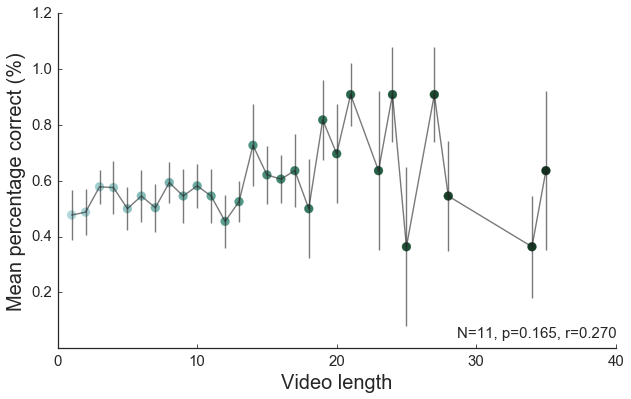

In [64]:
# accuracy proportion vs. video length
fig, axes = plt.subplots(1, 1, figsize=(10,6))

g3 = g2.groupby('length').mean().reset_index()

print(sts.linregress(g3.length, g3.correct))

y = [np.mean(g2_len[i]['correct']) for i in range(0,28,1)]
yerr = [1.96*np.std(g2_len[i]['correct'])/np.sqrt(11) for i in range(0,28,1)]
axes.errorbar(length, y, yerr,alpha=0.6)

plt.scatter(g3.length,g3.correct,s=80,color=greens)

plt.setp(
    axes, 
    ylabel='Mean percentage correct (%)', xlabel='Video length'
)

axes.set_xlim([0,40])
plt.xticks([0,10,20,30,40])
plt.yticks([0.2,0.4,0.6,0.8,1.0,1.2])

text = 'N=11, p=0.165, r=0.270'
plt.figtext(0.79,0.16,text, fontsize=15, ha='center', va='center', transform=axes.transAxes)

sns.despine()

In [21]:
g2_ave

,length,Unnamed: 0,clip_id,choice,feedback,timestamp,correct,discard,confidence,mean_confi,delta_confi
0,1,3071.875000,86.125000,44.556818,0.477273,1.480000e+12,0.477273,0.0,24.375000,24.30303,0.071970
1,2,3072.057851,67.818182,43.041322,0.487603,1.480000e+12,0.487603,0.0,22.578512,24.30303,-1.724518
2,3,3075.487603,83.272727,42.991736,0.578512,1.480000e+12,0.578512,0.0,23.206612,24.30303,-1.096419
3,4,3076.303030,125.666667,45.343434,0.575758,1.480000e+12,0.575758,0.0,24.252525,24.30303,-0.050505
4,5,3076.532468,93.071429,46.603896,0.500000,1.480000e+12,0.500000,0.0,23.863636,24.30303,-0.439394
5,6,3077.690909,73.700000,48.918182,0.545455,1.480000e+12,0.545455,0.0,22.445455,24.30303,-1.857576
6,7,3070.783217,69.769231,48.818182,0.503497,1.480000e+12,0.503497,0.0,21.839161,24.30303,-2.463870
7,8,3080.433155,83.411765,48.550802,0.593583,1.480000e+12,0.593583,0.0,24.882353,24.30303,0.579322
8,9,3059.772727,82.625000,42.636364,0.545455,1.480000e+12,0.545455,0.0,23.681818,24.30303,-0.621212
9,10,3070.593939,109.733333,54.448485,0.581818,1.480000e+12,0.581818,0.0,24.072727,24.30303,-0.230303


LinregressResult(slope=4.9887845997432567, intercept=-2.7197973899263408, rvalue=0.3262638282158935, pvalue=0.12866777264594625, stderr=3.1541044607147772)


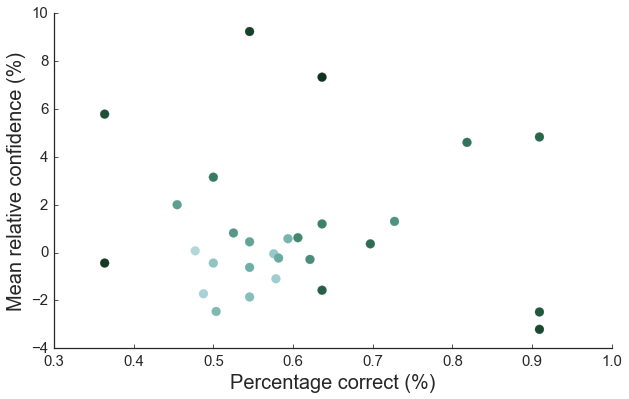

In [63]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

g2_ave = g2.groupby('length').mean().reset_index()
g4 = g2_ave.loc[g2_ave.length<=24]
print(sts.linregress(g4.correct, g4.delta_confi))

#plt.plot(g2_ave.correct, g2_ave.choice)
plt.scatter(g2_ave.correct, g2_ave.delta_confi,s=80,color=greens)

plt.setp(
    axes, 
    ylabel='Mean relative confidence (%)', xlabel='Percentage correct (%)'
)

#plt.xticks([0.2,0.4,0.6,0.8,1.0])
#plt.yticks([-4,-2,0,2,4,6,8,10])

#text = 'N=11, p=-0.054, r=0.786'
#plt.figtext(0.78,0.16,text, fontsize=16, ha='center', va='center', transform=axes.transAxes)

sns.despine()

In [51]:
i = g2.loc[g2.user_name==names[0], :]
print(sts.linregress(i.length.astype(int), i.choice.astype(int)))

LinregressResult(slope=0.24594422204969399, intercept=48.475001515234602, rvalue=0.12877997290461887, pvalue=0.084904935503793411, stderr=0.14195374890430068)


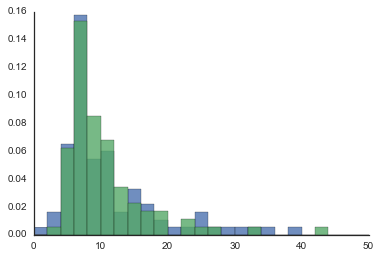

In [54]:
x = np.abs(50-i.loc[i.correct==1, 'choice'].values.astype(int))
y = np.abs(50-i.loc[i.correct==0, 'choice'].values.astype(int))
plt.hist(x, bins=np.arange(0, 51, 2), alpha=.8, normed=True)
plt.hist(y, bins=np.arange(0, 51, 2), alpha=.8, normed=True)
sns.despine()

In [57]:
sts.bayes_mvs(y)

(Mean(statistic=10.045454545454545, minmax=(8.9019471044246625, 11.188961986484426)),
 Variance(statistic=42.609625668449198, minmax=(32.993613868931611, 54.465155158054777)),
 Std_dev(statistic=6.5084347047508242, minmax=(5.7440067782804336, 7.380051162292494)))

In [58]:
sts.bayes_mvs(x)

(Mean(statistic=10.717391304347826, minmax=(9.4154805411418767, 12.019302067553774)),
 Variance(statistic=57.737664875427441, minmax=(44.970228974865648, 73.405684798262072)),
 Std_dev(statistic=7.577216652714883, minmax=(6.7059845641684594, 8.5677117597560457)))

## One offs:

(correcting errors)

In [87]:
# EXAMPLE: replace user_name field to be correct

F = {'user_name': }
U = {'$set': {'user_name': 'MJ'}}

C.update(F, U, multi=True)

{'n': 404, 'nModified': 404, 'ok': 1, 'updatedExisting': True}

In [19]:
# EXAMPLE: remove test user from database

F = {'user_name': {'$in': ['gianni', 'bas', 'test']}}

C.remove(F, multi=True)

{'n': 13, 'ok': 1}